### Importando as bibliotecas necessárias

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Obtenção dos dados

Foi realizado um método de "web scrapping" no site [https://www.airliners.net/](https://www.airliners.net/) e as imagens das aeronaves relativas às companhias Tam E Lufthansa foram salvas no diretório "C:\airplane_images".

Para ter acesso ao relatório de como foi feito o "web scrapping" das imagens basta acessar o notebook "Como realizar o Web Scrapping", incluso nessa página.

### Visualização do banco de dados

#### Lufthansa

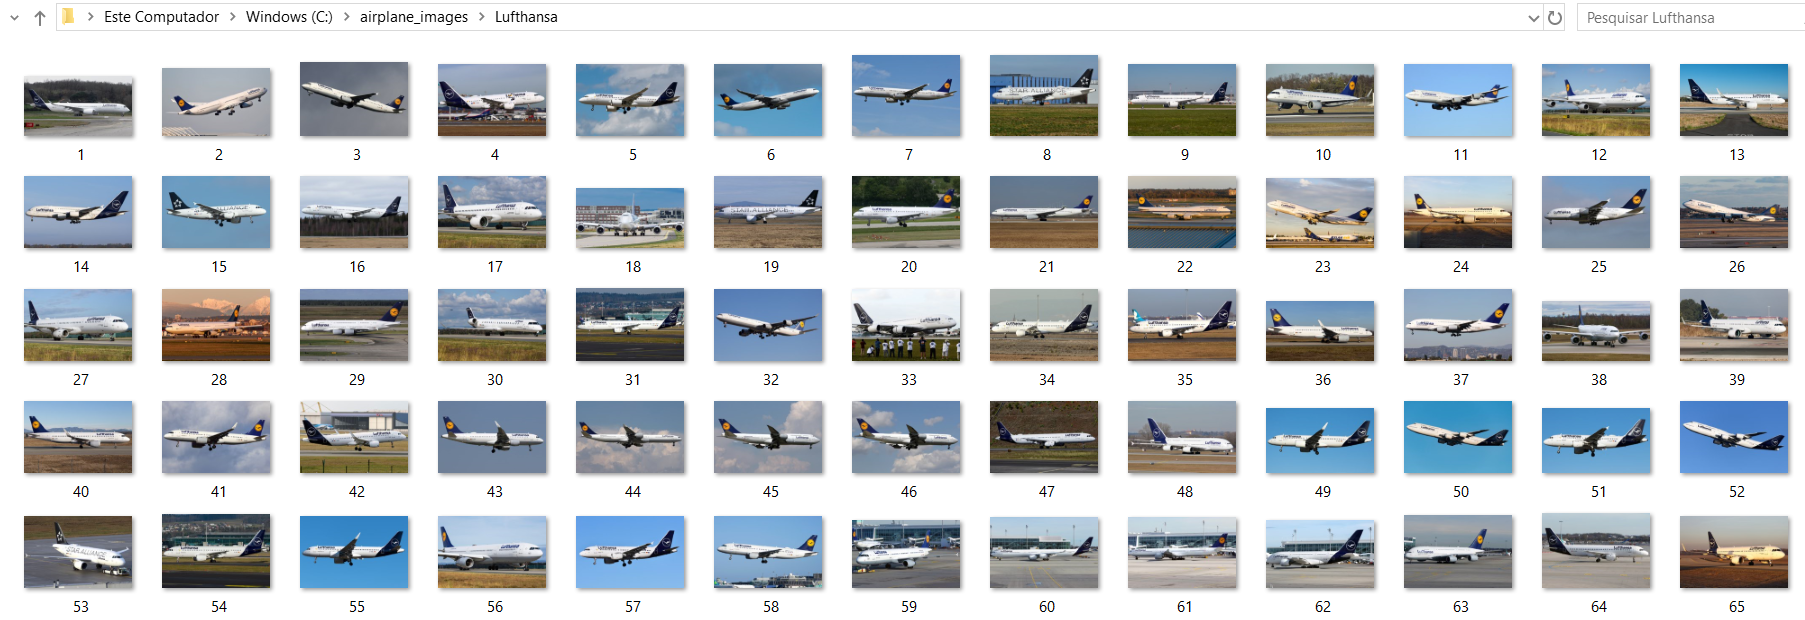

#### TAM

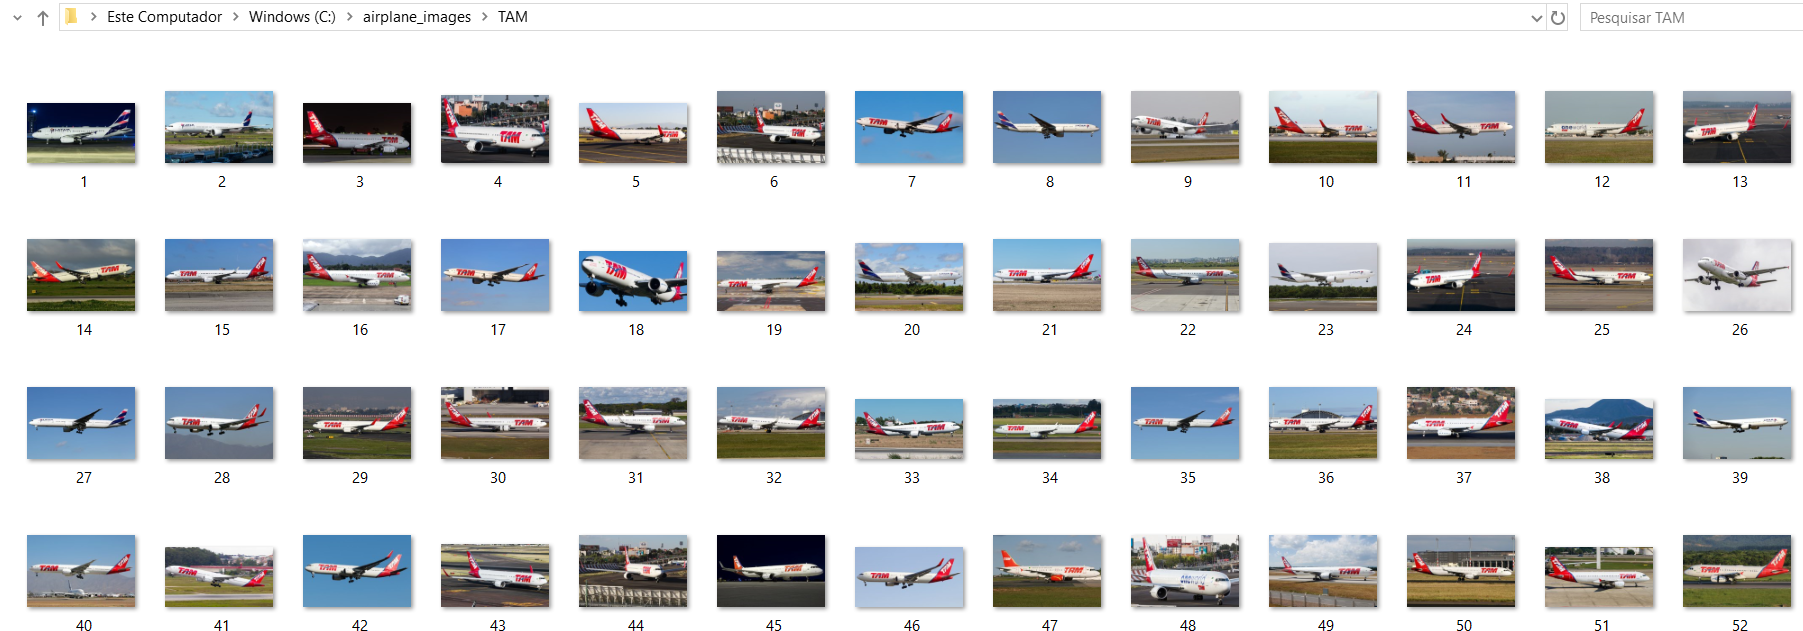

## Preparação dos dados

Formate as imagens em tensores de ponto flutuante pré-processados adequadamente antes de alimentar a rede:

* Leia imagens do disco.
* Decodifique o conteúdo dessas imagens e converta-o no formato de grade adequado, conforme o conteúdo RGB.
* Converta-os em tensores de ponto flutuante.
* Faça uma nova escala dos tensores de valores entre 0 e 255 para valores entre 0 e 1, pois as redes neurais preferem lidar com pequenos valores de entrada.

Felizmente, todas essas tarefas podem ser realizadas com a classe **ImageDataGenerator** fornecida por **tf.keras**. Ele pode ler imagens do disco e pré-processá-las em tensores adequados. Ele também configurará geradores que convertem essas imagens em lotes de tensores - úteis ao treinar a rede.

### Configurações dos dados

In [2]:
batch_size = 16
data_directory = "C:/airplane_images"
IMG_HEIGHT = 199
IMG_WIDTH = 300
class_mode = 'binary'
validation_split = 0.3

### Aumento de dados

O aumento de dados adota a abordagem de gerar mais dados de treinamento a partir de amostras de treinamento existentes, aumentando as amostras usando transformações aleatórias que produzem imagens com aparência crível.Isso ajuda a expor o modelo a mais aspectos dos dados e a generalizar melhor.

Como temos um grande banco de dados, não acreditamos que haverá problema com o overfitting. Entretanto, como imagens de aviões costumam ser tiradas de posições muito semelhantes, acreditamos que as transformações aleatórias ajudariam a diversificar os dados.

Implemente isso no tf.keras usando a classe ImageDataGenerator. Passe diferentes transformações para o conjunto de dados e ele se encarregará de aplicá-lo durante o processo de treinamento.

* Passe horizontal_flip e vertical_flip como argumentos para a classe ImageDataGenerator e defina-os como True para aplicar esses aumentos.
* Aplique 45 graus de rotação aleatoriamente nos exemplos de treinamento.
* Aplique um aumento de zoom ao conjunto de dados para ampliar imagens até 50% aleatoriamente.

Objeto ImageDataGenerator responsável por lidar com os arquivos de imagens

In [3]:
data_image_generator = ImageDataGenerator(rescale=1./255,
                                          zoom_range=0.5,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=45,
                                          validation_split=validation_split) # Generator for our data

Aqui, aplicamos:
* nova escala de revalorização
* rotação de 45 graus
* mudança de largura
* mudança de altura
* rotação horizontal
* zoom nas imagens de treinamento.

#### Separação dos dados treino/validação.

Separando os arquivos em arquivos destinados para treino e arquivos destinados para validação

In [4]:
train_generator = data_image_generator.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='training') # set as training data

Found 14556 images belonging to 2 classes.


In [5]:
validation_generator = data_image_generator.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='validation') # set as validation data

Found 6238 images belonging to 2 classes.


Observe aqui que as transformações relativas ao aumento dos dados está sendo aplicada em ambos os conjuntos, tanto de treino quanto de validação. O ideal seria aplica-los somente no conjunto de treino, porém como as transformações foram basicamente de rotação e "espelhamento" da imagem, não acreditamos que haverá grandes interferências

## Escolha do modelo

O modelo escolhido foi uma adaptação, através de técnicas de transferência de conhecimento, do modelo **ResNet50**.

O relatório sobre o parecer final do modelo de rede neural que deveria ser utilizado encontra-se nessa pasta, no notebook **"Escolha do modelo neural"**.
Lá estão discriminados os motivos que levaram à escolha desse modelo, juntamente com comparações a outros modelos ou a hipótese da manofatura de um modelo do zero.

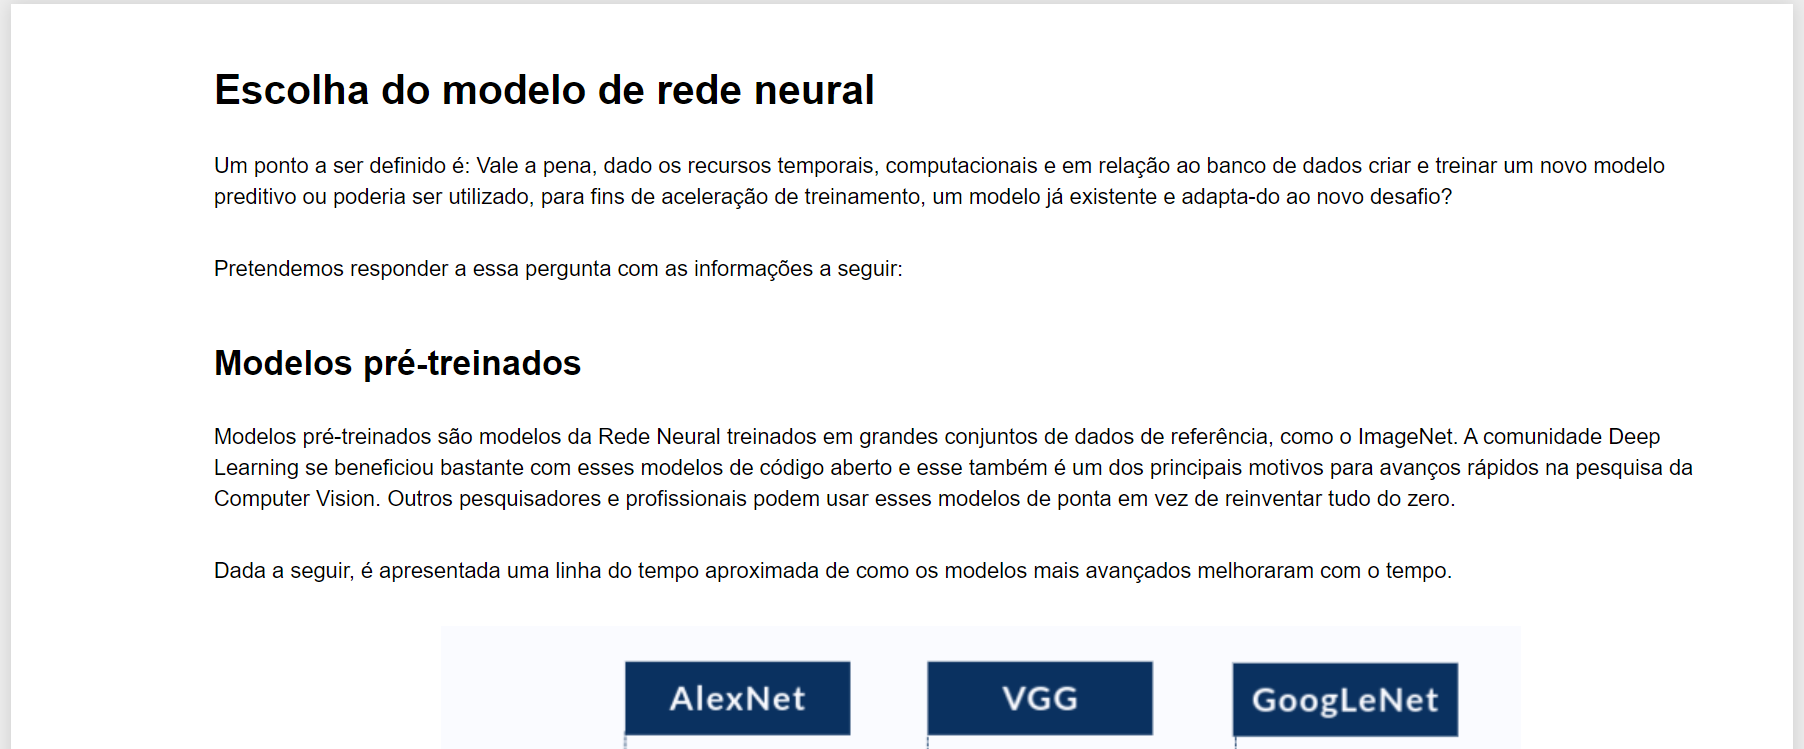

## Transferência de conhecimento

## Modelo ResNet50

A intuição por trás do aprendizado de transferência para classificação de imagens é que, se um modelo for treinado em um conjunto de dados grande e geral o suficiente, esse modelo servirá efetivamente como um modelo genérico do mundo visual. Você pode aproveitar esses mapas de recursos aprendidos sem precisar começar do zero treinando um modelo grande em um grande conjunto de dados.

Neste notebook, mostraremos duas maneiras de personalizar um modelo pré-treinado:

* **Extração de recursos**: use as representações aprendidas por uma rede anterior para extrair recursos significativos de novas amostras. Você simplesmente adiciona um novo classificador, que será treinado do zero, sobre o modelo pré-treinado, para que você possa adaptar novamente os mapas de recursos aprendidos anteriormente para o conjunto de dados.

 * Você não precisa (re) treinar o modelo inteiro. A rede convolucional de base já contém recursos que são genericamente úteis para classificar imagens. No entanto, a parte final de classificação do modelo pré-treinado é específica para a tarefa de classificação original e subsequentemente específica para o conjunto de classes em que o modelo foi treinado.

* **Ajuste fino**: descongele algumas das camadas superiores de uma base de modelo congelada e treine em conjunto as camadas de classificação recém-adicionadas e as últimas camadas do modelo de base. Isso nos permite "ajustar" as representações de recursos de ordem superior no modelo base para torná-las mais relevantes para a tarefa específica.

### Crie o modelo base a partir dos convnets pré-treinados

Criaremos o modelo base a partir do modelo **ResNet50**. Isso é pré-treinado no conjunto de dados ImageNet, um grande conjunto de dados composto por 1,4 milhões de imagens e 1000 classes. O ImageNet é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias, como jaca e seringa. Essa base de conhecimento nos ajudará a classificar a companhia aérea de nosso conjunto de dados específico.

Primeiro, precisaremos escolher qual camada do ResNet50 usaremos para extração de recursos. A última camada de classificação (na parte superior, como a maioria dos diagramas dos modelos de aprendizado de máquina vai de baixo para cima) não é muito útil. Em vez disso, seguiremos a prática comum de depender da última camada antes da operação de nivelamento. Essa camada é chamada de "camada de gargalo". Os recursos da camada de gargalo retêm mais generalidade em comparação com a camada final / superior.

Primeiro, instanciamos um modelo ResNet50 pré-carregado com pesos treinados no ImageNet. Ao especificar o argumento **include_top = False**, carregaremos uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para a extração de recursos.

In [6]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model.
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Esse extrator de recurso converte cada imagem de 300x200x3 em um bloco de recursos de 5x5x2048.

In [7]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 199, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 205, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 152, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Extração de recursos

Nesta etapa, congelaremos a base convolucional criada a partir da etapa anterior e utilizaremos como extrator de recursos. Além disso, adicionaremos um classificador sobre ele e treinaremos o classificador de nível superior.

#### Congelar a base convolucional

É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (configurando layer.trainable = False) impede que os pesos em uma determinada camada sejam atualizados durante o treinamento. O ResNet50 possui muitas camadas, portanto, definir o sinalizador treinável do modelo inteiro como False congelará todas as camadas.

In [8]:
base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 199, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 205, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 152, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

#### Adicionar uma cabeça de classificação

Para gerar previsões a partir do bloco de recursos, calcule a média das localizações espaciais 5x5 espaciais, usando uma camada **tf.keras.layers.GlobalAveragePooling2D** para converter os recursos em um único vetor de 2048 elementos por imagem.

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Aplique uma camada tf.keras.layers.Dense para converter esses recursos em uma única previsão por imagem.

In [11]:
prediction_layer = tf.keras.layers.Dense(1,
                                        activation='softmax')

Agora empilhe o extrator de recursos e essas duas camadas usando um modelo **tf.keras.Sequential**:

In [12]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#### Compilando o modelo

Devemos compilar o modelo antes de treiná-lo. Como existem duas classes, use uma **perda de entropia cruzada binária** (binary cross entropy) com **from_logits = True**, pois o modelo fornece uma saída linear.

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 10, 2048)       23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=14556 // 128,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=6238 // 128,
)

Epoch 1/5
113/113 [==============================] - 1225s 11s/step - loss: 0.7948 - accuracy: 0.5188 - val_loss: 0.8081 - val_accuracy: 0.5052
Epoch 2/5
113/113 [==============================] - 1233s 11s/step - loss: 0.7801 - accuracy: 0.5332 - val_loss: 0.8081 - val_accuracy: 0.5052
Epoch 3/5
113/113 [==============================] - 1242s 11s/step - loss: 0.8016 - accuracy: 0.5116 - val_loss: 0.8081 - val_accuracy: 0.5052
Epoch 4/5
113/113 [==============================] - 1323s 12s/step - loss: 0.8133 - accuracy: 0.5000 - val_loss: 0.8081 - val_accuracy: 0.5052
Epoch 5/5
113/113 [==============================] - 1355s 12s/step - loss: 0.7828 - accuracy: 0.5304 - val_loss: 0.8081 - val_accuracy: 0.5052


Como demonstrado pela 'accuracy' no treinamento acima, a precisão final foi muito abaixo do esperado. Vamos analizar melhor o treinamento:

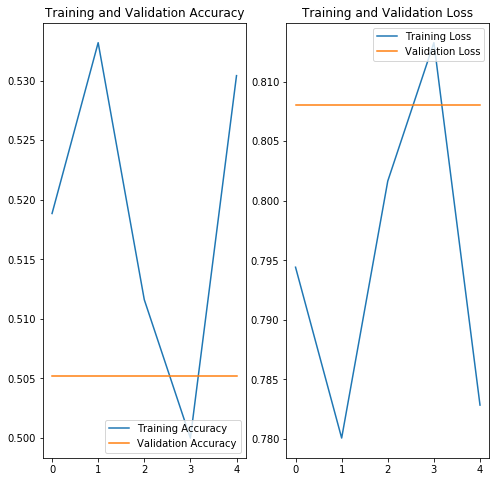

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como houve uma queda muito brusca na precisão, realizaremos os seguintes procedimentos:
* Redimensionamento das imagens.
* Diminuir o número de imagens no banco de dados, pois acredito que possa estar ocorrendo overfitting.
* Diminuir a taxa de aprendizado, a fim de suavizar e evitar mudanças bruscas.
* Aumentar o número de epochs.
* Não aplicar o aumento de data no set de validação.

#### Diminuição do número de imagens.

Para a diminuição do número de imagens, a maneira mais fácil é aumentar a porcentagem durante a separção entre grupo de teste e treinamento.

In [20]:
validation_split = 0.6

In [37]:
data_image_generator = ImageDataGenerator(rescale=1./255,
                                          zoom_range=0.5,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=45,
                                          validation_split=validation_split) # Generator for our data

In [38]:
train_generator = data_image_generator.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='training') # set as training data

Found 8318 images belonging to 2 classes.


In [39]:
validation_data_image_generator = ImageDataGenerator(rescale=1./255,
                                                    validation_split=validation_split)

In [40]:
validation_generator = validation_data_image_generator.flow_from_directory(
    data_directory,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=class_mode,
    subset='validation') # set as validation data

Found 12476 images belonging to 2 classes.


Dessa forma, como temos dois objetos ImageDataGenerator, pode acontecer de imagens usadas para o treinamento também serem usadas para a validação. Isso teoricamente diminuiu a confiabilidade das métricas atingidas, porém devido ao tamanho do banco de dados e de a mesma imagem não ser reutilizada várias vezes, acredito que será menos prejudicial do que aplicar o aumente de dados no set de validação.

#### Diminuição da taxa de aprendizado

In [25]:
#Diminuição em 100x
base_learning_rate = 0.000001

#### Aumento no número de epochs

In [31]:
epochs = 15

#### Recompilando o modelo

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Re-treinamento do modelo

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=8318 // 128,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=12476 // 128,
)

Epoch 1/15
64/64 [==============================] - 1050s 16s/step - loss: 0.7928 - accuracy: 0.5205 - val_loss: 0.7978 - val_accuracy: 0.5155
Epoch 2/15
64/64 [==============================] - 991s 15s/step - loss: 0.7820 - accuracy: 0.5312 - val_loss: 0.7978 - val_accuracy: 0.5155
Epoch 3/15
64/64 [==============================] - 1086s 17s/step - loss: 0.8025 - accuracy: 0.5107 - val_loss: 0.7978 - val_accuracy: 0.5155
Epoch 4/15
64/64 [==============================] - 1161s 18s/step - loss: 0.7937 - accuracy: 0.5195 - val_loss: 0.7978 - val_accuracy: 0.5155
Epoch 5/15
64/64 [==============================] - 1133s 18s/step - loss: 0.7918 - accuracy: 0.5215 - val_loss: 0.7978 - val_accuracy: 0.5155
Epoch 6/15
64/64 [==============================] - 938s 15s/step - loss: 0.7986 - accuracy: 0.5146 - val_loss: 0.7978 - val_accuracy: 0.5155
Epoch 7/15
64/64 [==============================] - 878s 14s/step - loss: 0.8123 - accuracy: 0.5010 - val_loss: 0.7978 - val_accuracy: 0.5155
Ep

#### Avaliação

Infelizmente, houve um erro e o treinamento não pode ser completamente concluido. Porém, notasse que não houve melhora na acurrácia ou diminuição do custo.

Alguns motivos que podem ter sido os responsáveis:
   * As feastures entre as duas classes de aviões são muito parecidas, e como o modelo pre-treinado não foi treinado especificamente para distinguir as duas classes, a extração de recursos pode ter sido ineficiente.
   * O tamanho do batch de imagens estava muito grande, prejudicando a suavização do treinamento e levando a bruscas correções.
   * A compactação das imagens para se encaixar no formato de input podem te-las retirado informações importantes, necessárias para a correta implementação.

De toda forma, devido ao relativamente baixo processamento computacional da minha máquina, será adotado a realização de um modelo "do zero".

Obs: Inicialmente a proposta era realizar um "ajuste fino" (Fina tunning) no modelo pré-treinado, onde seriam descongeladas algumas de suas últimas camadas e re-treinadas. A expectativa é que essa abordagem melhoraria percentualemente a precisão do modelo.

### Modelo "do zero"

#### Pre-processamento dos dados

* Antes de tudo, para evitar a problemática relativa à separação dos dados e a aplicação das técnicas de aumento de dados, separararemos nosso diretório antecipadamente

In [8]:
train_dir = 'C:/airplane_images\Treinamento'
validation_dir = 'C:/airplane_images\Validação'

A separação foi feita na proporção 0.7/0.3

####  Entendendo os dados

In [9]:
train_TAM_dir = os.path.join(train_dir, 'TAM')
train_Lufthansa_dir = os.path.join(train_dir, 'Lufthansa')
validation_TAM_dir = os.path.join(validation_dir, 'TAM')
validation_Lufthansa_dir = os.path.join(validation_dir, 'Lufthansa')

In [10]:
num_TAM_tr = len(os.listdir(train_TAM_dir))
num_Lufthansa_tr = len(os.listdir(train_Lufthansa_dir))

num_TAM_val = len(os.listdir(validation_TAM_dir))
num_Lufthansa_val = len(os.listdir(validation_Lufthansa_dir))

total_train = num_TAM_tr + num_Lufthansa_tr
total_val = num_TAM_val + num_Lufthansa_val

In [11]:
print('total training TAM images:', num_TAM_tr)
print('total training Lufthansa images:', num_Lufthansa_tr)

print('total validation TAM images:', num_TAM_val)
print('total validation Lufthansa images:', num_Lufthansa_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training TAM images: 7000
total training Lufthansa images: 7000
total validation TAM images: 3000
total validation Lufthansa images: 3000
--
Total training images: 14000
Total validation images: 6000


#### Configurações

In [12]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 300

### Preparando os dados

#### Aumento de dados

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          zoom_range=0.5,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=45) # Generator for our training data

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Repare que está sendo aplicadas transformações no conjunto de treino e somente no conjunto de treino.

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 14000 images belonging to 2 classes.


In [16]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 6000 images belonging to 2 classes.


#### Visualizando imagens

Visualize as imagens de treinamento extraindo um lote de imagens do gerador de treinamento - que são 32 imagens neste exemplo - e plote cinco delas com matplotlib.

In [22]:
sample_training_images, _ = next(train_data_gen)
sample_val_images, _ = next(val_data_gen)

A próxima função retorna um lote do conjunto de dados. O valor de retorno da próxima função está na forma de (x_train, y_train) em que x_train está treinando recursos e y_train, seus rótulos. Descarte os rótulos para visualizar apenas as imagens de treinamento.

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

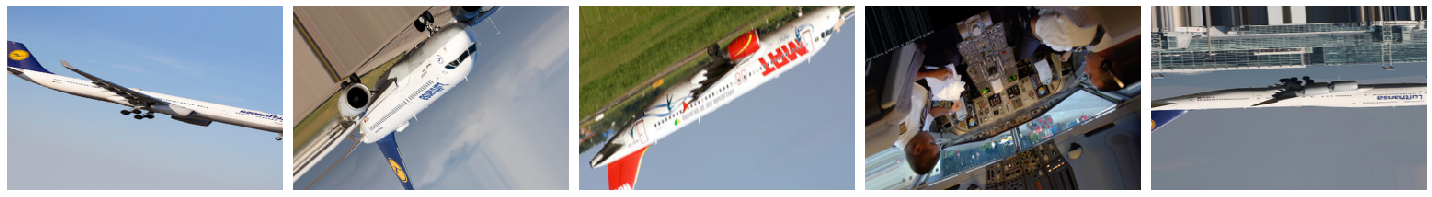

In [23]:
plotImages(sample_training_images[:5])

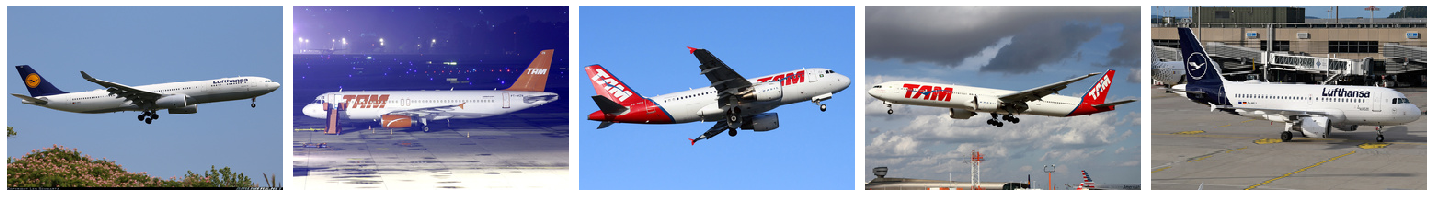

In [24]:
plotImages(sample_val_images[:5])

Observe que as transformações já foram aplicadas no conjunto de treinamento.

### Criando o modelo

Começaremos com um modelo simples, baseado em 3 camadas convulocionais, com suas respectvas camadas "MaxPooling", e uma camada linear com 512 saída. Esse modelo será usado como hipótese para verificarmos se é possível que um modelo mais simples se adegue bem a esse banco de dados

In [25]:
conv_model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [34]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59200)             0

Note que o número de parâmetros treináveis é bem maior em relação ao modelo pré-treinado, porém o número total de parâmetros caiu drasticamente.

#### Compilando o modelo

In [26]:
conv_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Treinando o modelo

In [28]:
history = conv_model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
109/109 [==============================] - 1192s 11s/step - loss: 0.4108 - accuracy: 0.8671 - val_loss: 0.1608 - val_accuracy: 0.9540
Epoch 2/15
109/109 [==============================] - 1214s 11s/step - loss: 0.1460 - accuracy: 0.9496 - val_loss: 0.1185 - val_accuracy: 0.9555
Epoch 3/15
109/109 [==============================] - 1045s 10s/step - loss: 0.1304 - accuracy: 0.9549 - val_loss: 0.1117 - val_accuracy: 0.9603
Epoch 4/15
109/109 [==============================] - 1295s 12s/step - loss: 0.1113 - accuracy: 0.9586 - val_loss: 0.1009 - val_accuracy: 0.9623
Epoch 5/15
109/109 [==============================] - 697s 6s/step - loss: 0.1080 - accuracy: 0.9588 - val_loss: 0.1121 - val_accuracy: 0.9633
Epoch 6/15
109/109 [==============================] - 774s 7s/step - loss: 0.0989 - accuracy: 0.9609 - val_loss: 0.0973 - val_accuracy: 0.9660
Epoch 7/15
109/109 [==============================] - 733s 7s/step - loss: 0.0950 - accuracy: 0.9650 - val_loss: 0.1140 - val_accuracy

#### Avaliando o treinamento

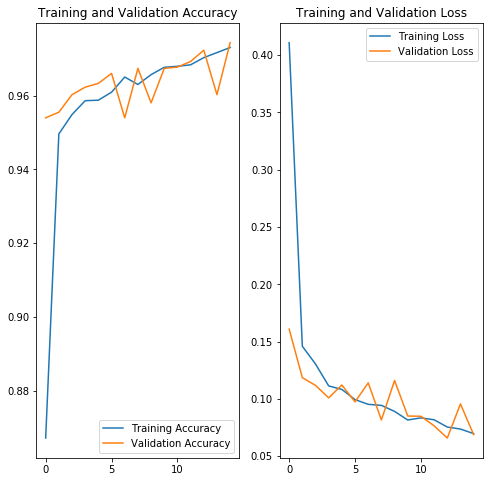

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nesse caso, surpreendentemente em relação ao modelo anterior, conseguirmos uma precisão média de mais de 96%,  consideração o grupo de validação. Esse dado particularmente me surpreendeu, pois essa proposta de modelo era inicialmente um rascunho de modelo, usado com a intenção de verificar a viabilidade de um modelo mais simples se adequar ao desafio. Eram esperadas ainda técnicas de refino e melhora nos hiperparâmetros para atingir uma acurácia tão alta.

### Avaliação

Esses dados me levantaram 2 hipóteses:

* O modelo de rede neural se encaixou muito bem á proposta: Bastava identificar algumas poucas características da imagem para classifica-la corretamente, uma cor específica, logo ou nome da compania.E dessa maneira, as camadas convulocionais se adeguaram muito bem.

ou

* O banco de dados por si só estava muito repetitivo e pouco diverso, permitindo que a rede "memorizasse" as respostas do grupo de validação pois haviam exemplos muito parecidos no grupo de treinamento. Vejo necessário realizar essa observação, pois limitaria a aplicabilidade prática do modelo: Apesar de se adequar muito bem a esse conjunto específico de dados, talvez não pudesse ser utilizado em uma aplicação real, devido à diversidade e pluralidade de formas que os exemplos reais tomariam. Torna-se, portanto, necessária uma avaliação prática do modelo.

### Salvando o modelo

O modelo será salvo no formato SavedModel, no diretório 'C:\Saved_Model'.

In [38]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
conv_model.save('C:\Saved_Model') 

INFO:tensorflow:Assets written to: C:\Saved_Model\assets


#### SavedModel Object

O formato SavedModel é outra maneira de serializar modelos. Os modelos salvos nesse formato podem ser restaurados usando tf.keras.models.load_model e são compatíveis com o TensorFlow Serving.

O formato SavedModel é um diretório que contém um binário protobuf e um ponto de verificação Tensorflow.

#### Carregando o modelo

Para carregar o modelo, para utilizar-mos a seguinte função:

In [39]:
new_model = tf.keras.models.load_model('C:\Saved_Model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59200)             0